# Goat Format Deck Classification Model

Building an XGBoost model to classify Goat Format deck archetypes using main deck data from top tournament performances.

## Table of Contents

1. [Setup](#1-setup)
   - [Library Imports](#library-imports)
2. [Data Loading](#2-data-loading)
   - [Data Source](#data-source)
   - [Initial Processing](#initial-processing)
   - [Data Structure Overview](#data-structure-overview)
3. [Exploratory Data Analysis](#3-exploratory-data-analysis)
   - [Event Statistics](#event-statistics)
     - [Series Overview](#series-overview)
     - [Placement Distribution](#placement-distribution)
   - [Deck Analysis](#deck-analysis)
     - [Deck Type Analysis](#deck-type-analysis)
     - [Year-by-Year Breakdown](#year-by-year-breakdown)
     - [Deck Size Distribution](#deck-size-distribution)
   - [Data Quality](#data-quality)
     - [Card Count](#card-count)
     - [Label Verification](#label-verification)
     - [Edge Cases (Min Tails)](#edge-cases-min-tails)
4. [Model Development](#4-model-development)
   - [Data Processing](#data-processing)
     - [Preparation](#preparation)
     - [Train-Test Split](#train-test-split)
     - [Data Augmentation](#data-augmentation)
   - [Feature Engineering](#feature-engineering)
     - [TF-IDF Pipeline](#tf-idf-pipeline)
     - [TF Plot](#tf-plot)
     - [IDF Plot](#idf-plot)
   - [Model Training](#model-training)
     - [Class Imbalance Handling](#class-imbalance-handling)
     - [Cross Validation](#cross-validation)
     - [Cross Validation Plot](#cross-validation-plot)
   - [Model Evaluation](#model-evaluation)
     - [Overall Performance](#overall-performance)
     - [Partial Deck Performance](#partial-deck-performance)
     - [Confusion Matrix](#confusion-matrix)
   - [Save the Model](#save-the-model)

## 1. Setup

### Library Imports

In [1]:
import joblib
import numpy as np
import pandas as pd
import polars as pl
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from plotnine import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder

from gfwldata.utils.db import sync_engine
from notebooks.utils import reorder_within

## 2. Data Loading

Loading and preprocessing tournament deck data from FormatLibrary.


### Data Source

Dataset comprises pre-processed main deck lists from top-performing Goat Format tournament decks on FormatLibrary.com.

In [2]:
raw_event_decks = pl.read_database(
    """
    select 
        published_at,
        deck_category,
        deck_class,
        card_name,
        card_amount,
        deck_builder,
        event_name,
        event_placement,
        url
    from event_decks
    where deck_type == 'main';
    """,
    connection=sync_engine,
)

with pl.Config(tbl_rows=2):
    print(raw_event_decks)

shape: (45_125, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ published ┆ deck_cate ┆ deck_clas ┆ card_name ┆ … ┆ deck_buil ┆ event_nam ┆ event_pla ┆ url      │
│ _at       ┆ gory      ┆ s         ┆ ---       ┆   ┆ der       ┆ e         ┆ cement    ┆ ---      │
│ ---       ┆ ---       ┆ ---       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str      │
│ str       ┆ str       ┆ str       ┆           ┆   ┆ str       ┆ str       ┆ i64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2025-03-2 ┆ Aggro     ┆ Warrior   ┆ Black     ┆ … ┆ DuelingHi ┆ PWCQ73    ┆ 1         ┆ https:// │
│ 2 23:07:4 ┆           ┆           ┆ Luster    ┆   ┆ gh101     ┆           ┆           ┆ formatli │
│ 7.373000  ┆           ┆           ┆ Soldier - ┆   ┆           ┆           ┆           ┆ brary.co │
│           ┆           ┆           ┆ Envoy o…  ┆   ┆           ┆       

### Initial Processing


First we're going to look for any nulls in the dataset. Shouldn't be any from the pre-processing done at the scraping stage but just to double-check.

In [3]:
raw_event_decks.null_count()

published_at,deck_category,deck_class,card_name,card_amount,deck_builder,event_name,event_placement,url
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0


Next, we're going to alter the dataset a bit:

- Remove `/api` patterns from the url column so I can view the decks easier
- Create `published_date` from `published_at` to do year-by-year analysis
- Drop `published_at` altogether

We'll save this altered dataset as a new dataframe.

In [4]:
event_decks = (
    raw_event_decks.with_columns(
        url=pl.col("url").str.replace("/api", ""),
        published_at=pl.col("published_at").str.to_datetime(time_unit="us"),
    )
    .with_columns(published_date=pl.col("published_at").dt.date())
    .select("published_date", pl.all().exclude("published_at", "published_date"))
)

with pl.Config(tbl_rows=2):
    print(event_decks)

shape: (45_125, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ published ┆ deck_cate ┆ deck_clas ┆ card_name ┆ … ┆ deck_buil ┆ event_nam ┆ event_pla ┆ url      │
│ _date     ┆ gory      ┆ s         ┆ ---       ┆   ┆ der       ┆ e         ┆ cement    ┆ ---      │
│ ---       ┆ ---       ┆ ---       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str      │
│ date      ┆ str       ┆ str       ┆           ┆   ┆ str       ┆ str       ┆ i64       ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2025-03-2 ┆ Aggro     ┆ Warrior   ┆ Black     ┆ … ┆ DuelingHi ┆ PWCQ73    ┆ 1         ┆ https:// │
│ 2         ┆           ┆           ┆ Luster    ┆   ┆ gh101     ┆           ┆           ┆ formatli │
│           ┆           ┆           ┆ Soldier - ┆   ┆           ┆           ┆           ┆ brary.co │
│           ┆           ┆           ┆ Envoy o…  ┆   ┆           ┆       

Currently, we have our `event_decks` dataframe which has all of the main-deck cards for each top event decks. However, for a lot of our EDA later we're going to create a new dataframe called `grouped_event_decks` to group these decks into one row - removing individual cards.

In [5]:
grouped_event_decks = (
    event_decks.select(pl.all().exclude("card_name", "card_amount"))
    .unique()
    .sort(by=["published_date", "event_placement"], descending=[True, False])
)

with pl.Config(tbl_rows=2):
    print(grouped_event_decks)

shape: (1_648, 7)
┌──────────────┬──────────────┬─────────────┬─────────────┬────────────┬─────────────┬─────────────┐
│ published_da ┆ deck_categor ┆ deck_class  ┆ deck_builde ┆ event_name ┆ event_place ┆ url         │
│ te           ┆ y            ┆ ---         ┆ r           ┆ ---        ┆ ment        ┆ ---         │
│ ---          ┆ ---          ┆ str         ┆ ---         ┆ str        ┆ ---         ┆ str         │
│ date         ┆ str          ┆             ┆ str         ┆            ┆ i64         ┆             │
╞══════════════╪══════════════╪═════════════╪═════════════╪════════════╪═════════════╪═════════════╡
│ 2025-03-22   ┆ Aggro        ┆ Warrior     ┆ DuelingHigh ┆ PWCQ73     ┆ 1           ┆ https://for │
│              ┆              ┆             ┆ 101         ┆            ┆             ┆ matlibrary. │
│              ┆              ┆             ┆             ┆            ┆             ┆ com/deck…   │
│ …            ┆ …            ┆ …           ┆ …           ┆ …          ┆ 

### Data Structure Overview

We have two dataframes now, `event_decks` and `grouped_event_decks`. Let's take a closer look at how these dataframes are structured.


#### Event Decks

Has the following column definitions:

- published_date = The date that the deck was published to formatlibrary.com
- deck_class = The deck class, or type, eg. Chaos Turbo
- deck_category = The deck category, eg. Control or Aggro
- card_name = The name of the card in a deck
- card_amount = The number of cards in a deck, eg. 1-3
- deck_builder = The deck builder's duelingbook username
- event_name = The name of the event, eg. FLC21
- event_placement = The deck's placement for an event
- url = The now modified formatlibrary url that shows the deck


Here's an example of what a deck looks like in the `event_decks` dataframe. There's 29 unique cards in this deck, built by "DuelingHigh101", that has placed 1st at the PWCQ73.

In [6]:
example_url = event_decks["url"][0]

print(
    event_decks.filter(pl.col("url") == example_url).select(
        "deck_class",
        "card_name",
        "card_amount",
        "deck_builder",
        "event_name",
        "event_placement",
    )
)

shape: (29, 6)
┌────────────┬───────────────────────┬─────────────┬────────────────┬────────────┬─────────────────┐
│ deck_class ┆ card_name             ┆ card_amount ┆ deck_builder   ┆ event_name ┆ event_placement │
│ ---        ┆ ---                   ┆ ---         ┆ ---            ┆ ---        ┆ ---             │
│ str        ┆ str                   ┆ i64         ┆ str            ┆ str        ┆ i64             │
╞════════════╪═══════════════════════╪═════════════╪════════════════╪════════════╪═════════════════╡
│ Warrior    ┆ Black Luster Soldier  ┆ 1           ┆ DuelingHigh101 ┆ PWCQ73     ┆ 1               │
│            ┆ - Envoy o…            ┆             ┆                ┆            ┆                 │
│ Warrior    ┆ Blade Knight          ┆ 3           ┆ DuelingHigh101 ┆ PWCQ73     ┆ 1               │
│ Warrior    ┆ Breaker the Magical   ┆ 1           ┆ DuelingHigh101 ┆ PWCQ73     ┆ 1               │
│            ┆ Warrior               ┆             ┆                ┆       

Here's that same deck in the `grouped_event_decks` dataframe. There's just one row that doesn't hold the main deck card data.

In [7]:
print(
    grouped_event_decks.filter(pl.col("url") == example_url).select(
        "deck_class", "deck_builder", "event_name", "event_placement"
    )
)

shape: (1, 4)
┌────────────┬────────────────┬────────────┬─────────────────┐
│ deck_class ┆ deck_builder   ┆ event_name ┆ event_placement │
│ ---        ┆ ---            ┆ ---        ┆ ---             │
│ str        ┆ str            ┆ str        ┆ i64             │
╞════════════╪════════════════╪════════════╪═════════════════╡
│ Warrior    ┆ DuelingHigh101 ┆ PWCQ73     ┆ 1               │
└────────────┴────────────────┴────────────┴─────────────────┘


## 3. Exploratory Data Analysis

We're going to do a deeper dive into these dataframes to get an understanding of what's going into our model.


### Event Statistics


#### Series Overview

How many series do we have? Of them, how many events and topping decks?

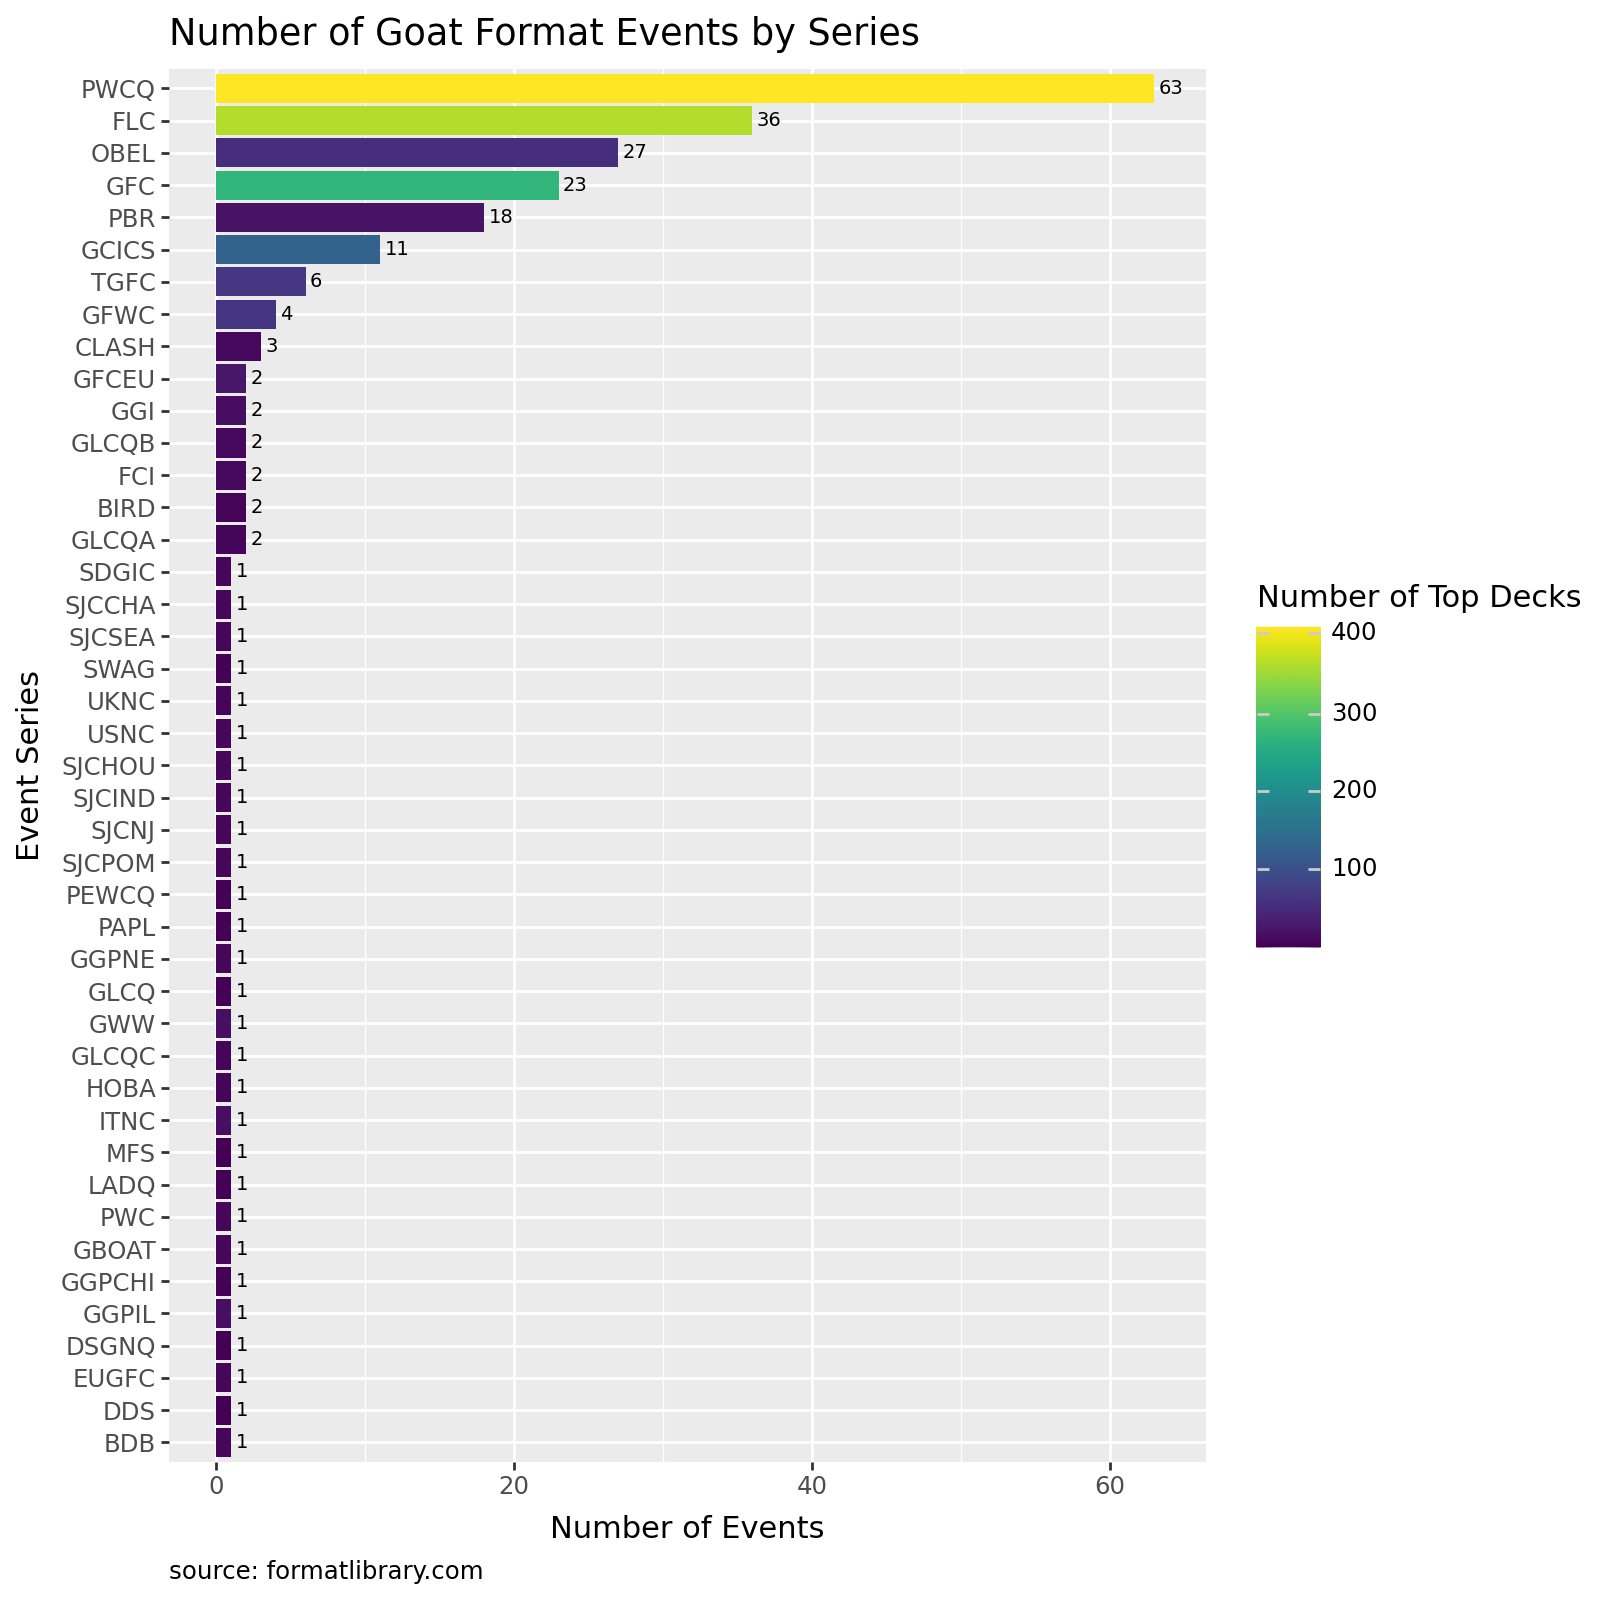

In [8]:
tournament_count = (
    grouped_event_decks.with_columns(
        event_series=pl.col("event_name").str.replace(r"\d+", "")
    )
    .group_by("event_series")
    .agg(
        [
            pl.col("event_name").n_unique().alias("unique_events"),
            pl.len().alias("total_decks"),
            pl.col("published_date").max().alias("last_date"),
        ]
    )
    .sort("unique_events", descending=True)
)

(
    ggplot(tournament_count.to_pandas())
    + geom_bar(
        aes(
            x="reorder(event_series, unique_events)",
            y="unique_events",
            fill="total_decks",
        ),
        stat="identity",
    )
    + geom_text(
        aes(
            x="reorder(event_series, unique_events)",
            y="unique_events",
            label="unique_events",
        ),
        ha="left",
        va="center",
        nudge_y=0.3,
        size=7,
    )
    + coord_flip()
    + labs(
        title="Number of Goat Format Events by Series",
        x="Event Series",
        y="Number of Events",
        fill="Number of Top Decks",
        caption="source: formatlibrary.com",
    )
    + theme(
        figure_size=(8, 8),
        title=element_text(ha="left"),
        axis_title_x=element_text(ha="center")
    )
)

Unsurprisingly, the series with the most events has the most decks in our dataset. However, it isn't the case for smaller events like OBEL, which finds itself above GFC's in terms of number of events but has less topping decks overall.


#### Placement Distribution

All public decks in FormatLibrary are topping decks. How that's defined depends on the number of participants in that event. I didn't collect total participant data during the scrape, but we can get an idea of the range of top placements that are in our dataset with a distribution.

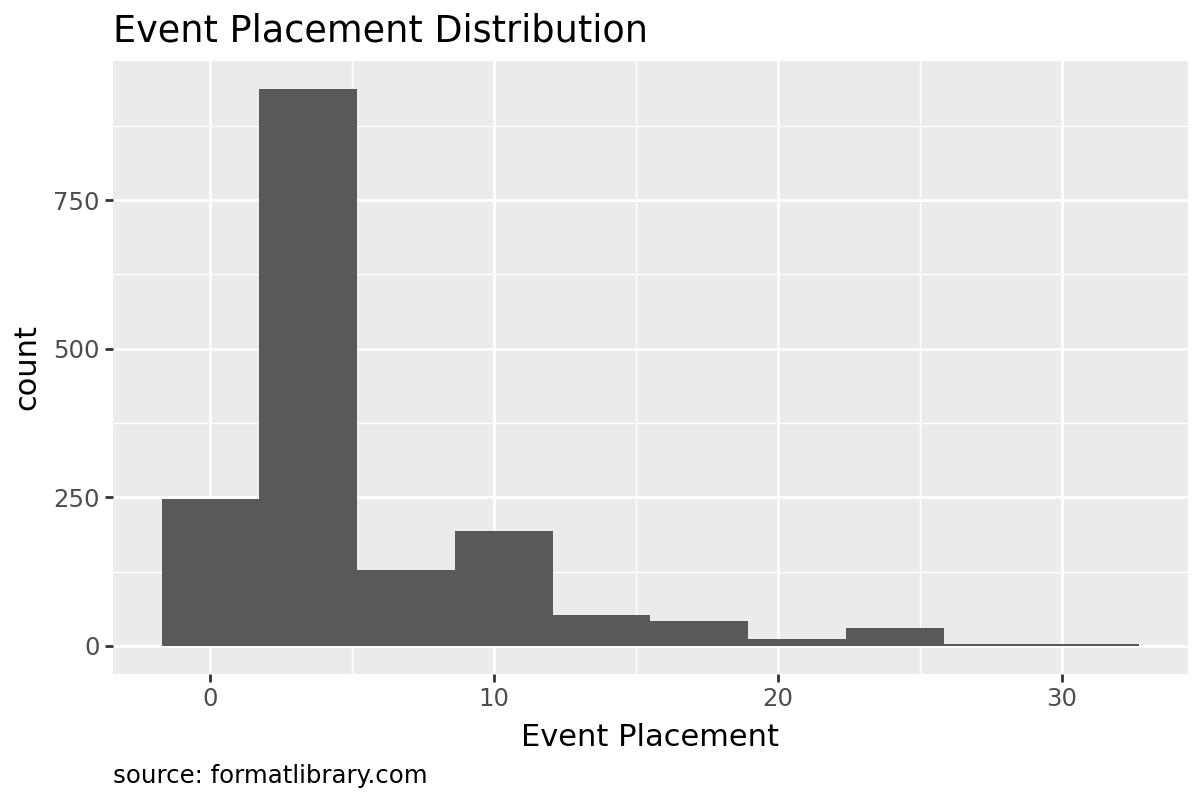

In [9]:
(
    ggplot(
        data=grouped_event_decks.to_pandas(),
    )
    + geom_histogram(aes(x="event_placement"), bins=10)
    + labs(
        title="Event Placement Distribution",
        x="Event Placement",
        caption="source: formatlibrary.com",
    )
    + theme(
        figure_size=(6, 4),
        title=element_text(ha="left"),
        axis_title_x=element_text(ha="center")
    )
)

In [10]:
print(grouped_event_decks.get_column("event_placement").describe())

shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 1648.0   │
│ null_count ┆ 0.0      │
│ mean       ┆ 5.396845 │
│ std        ┆ 4.853686 │
│ min        ┆ 1.0      │
│ 25%        ┆ 2.0      │
│ 50%        ┆ 4.0      │
│ 75%        ┆ 7.0      │
│ max        ┆ 32.0     │
└────────────┴──────────┘


### Deck Analysis

Now that we've done some analysis on the events of these decks, let's take a look at the decks themselves.


#### Deck Type Analysis

The total number of decks for each deck type.

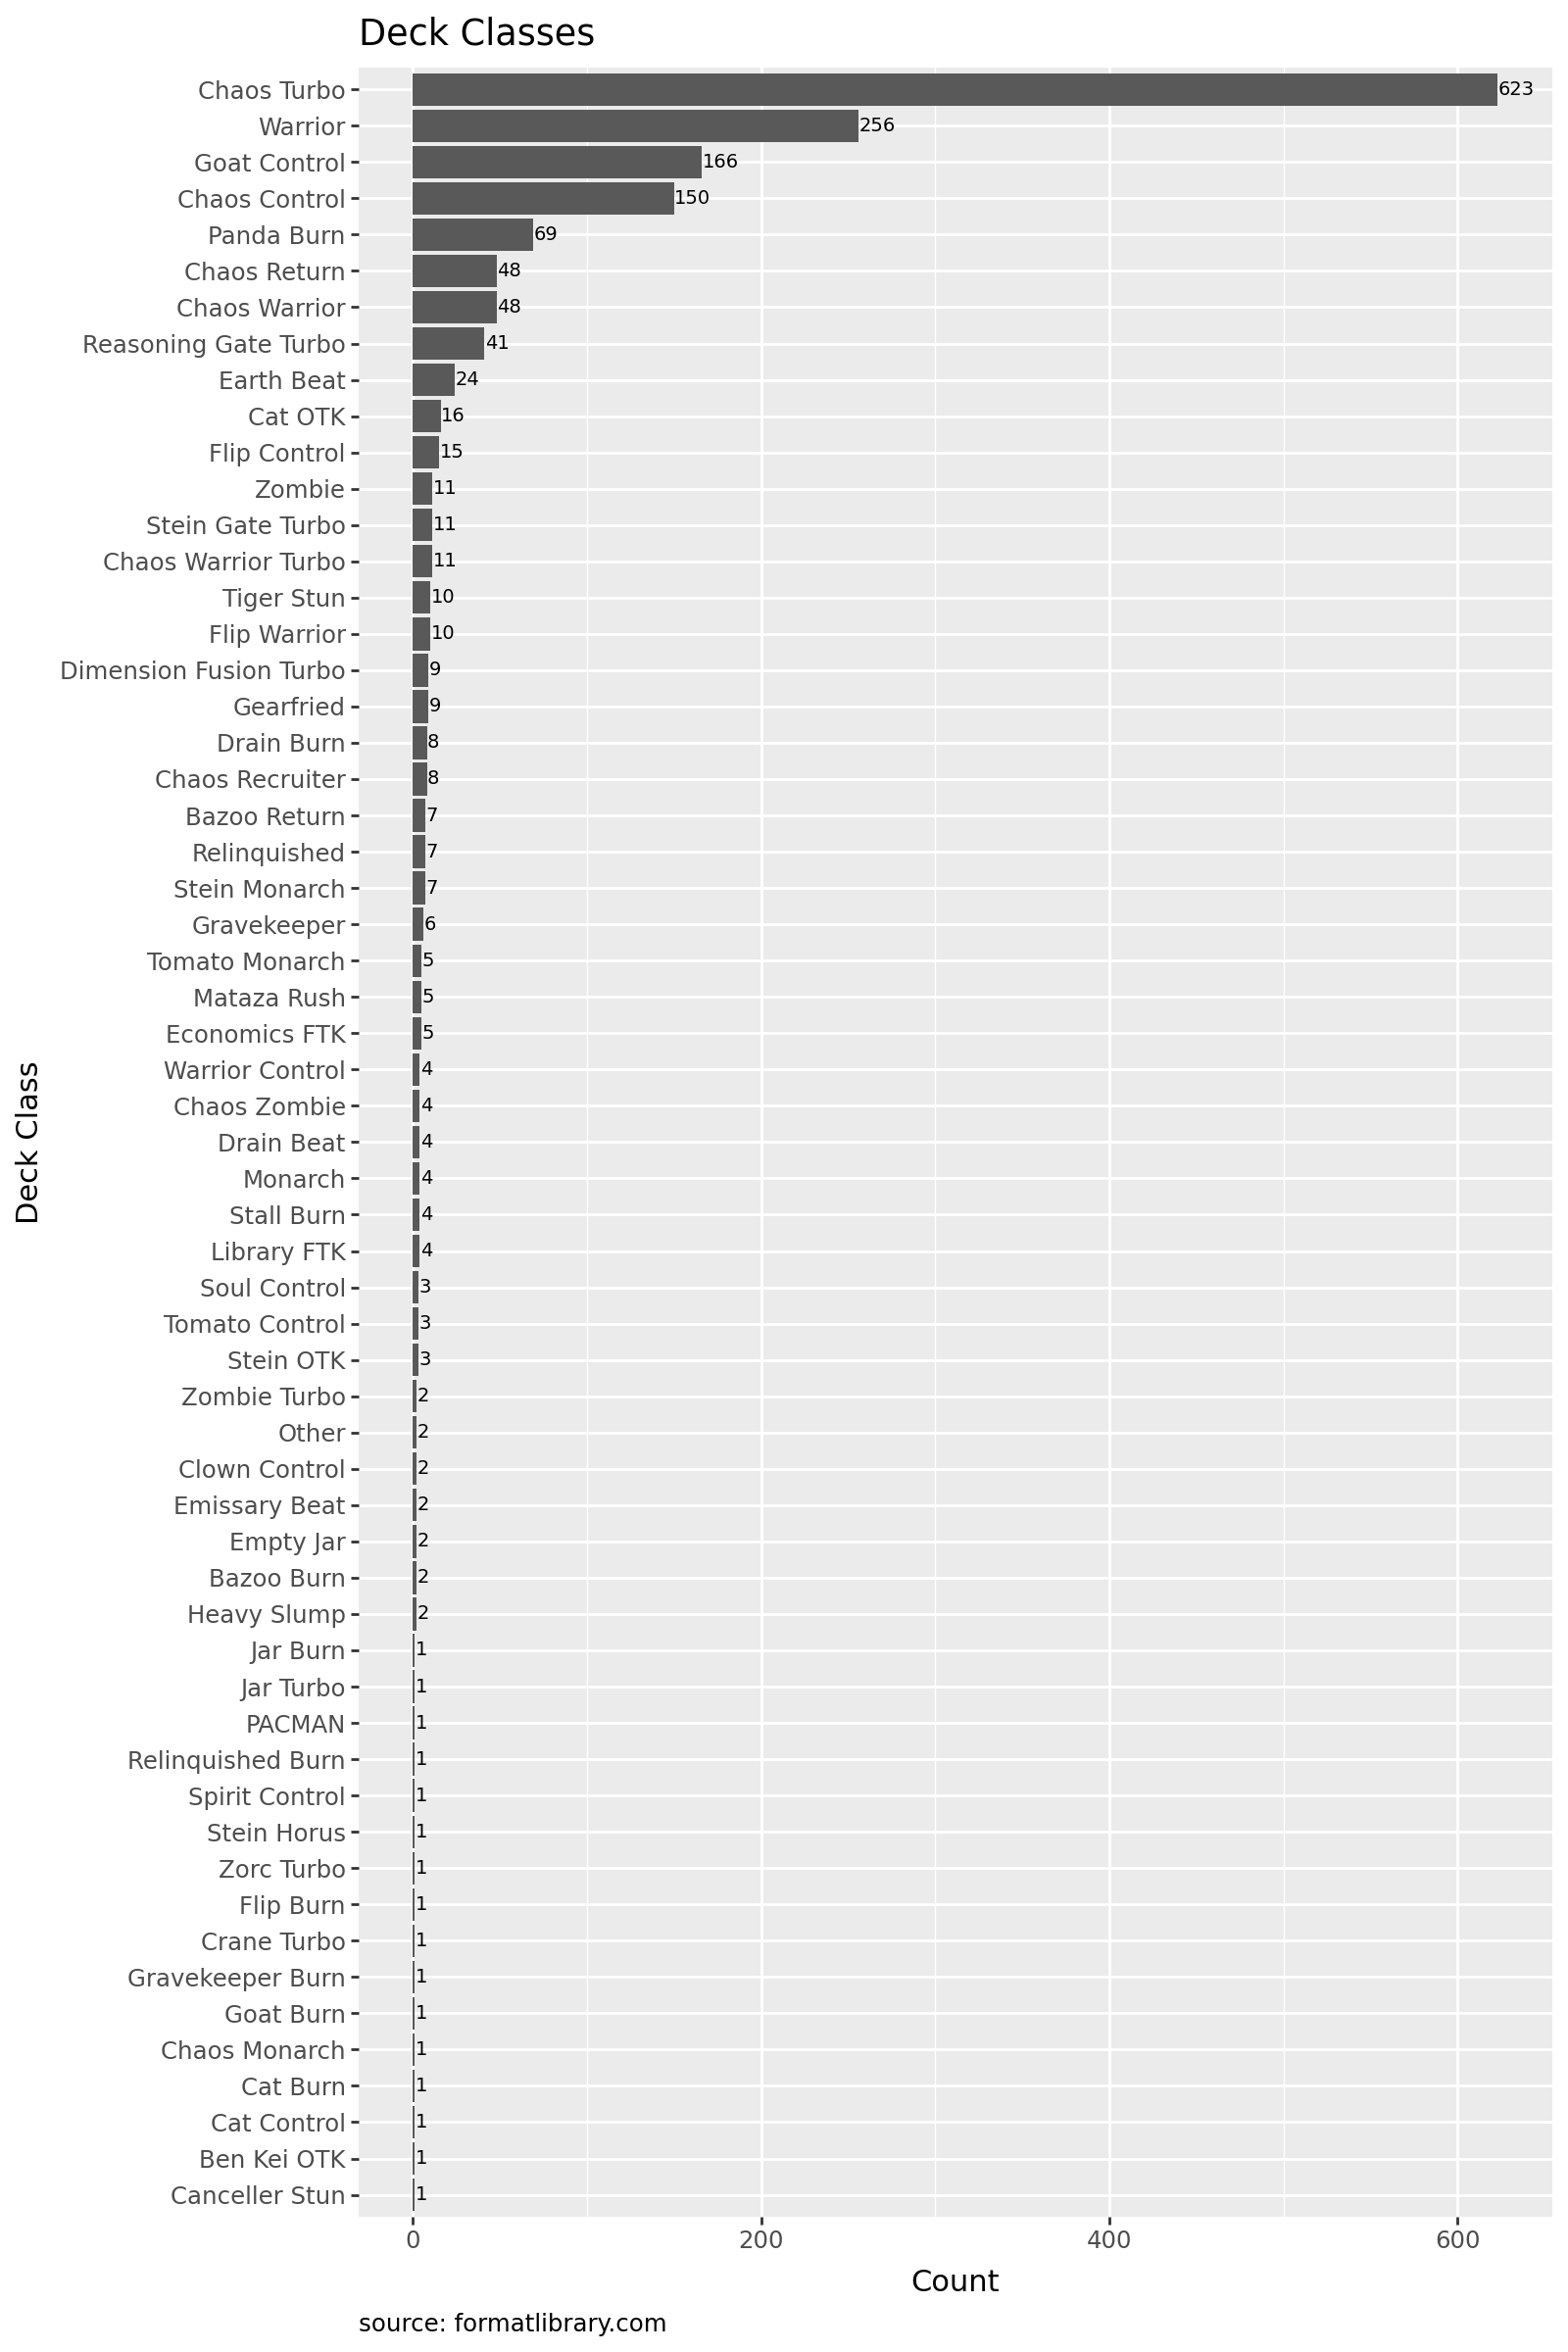

In [11]:
deck_types_count = (
    grouped_event_decks.group_by("deck_class").len().sort("len", descending=True)
)

(
    ggplot(deck_types_count.to_pandas())
    + geom_bar(
        aes(
            x="reorder(deck_class, len)",
            y="len",
        ),
        stat="identity",
    )
    + geom_text(
        aes(
            x="reorder(deck_class, len)",
            y="len",
            label="len",
        ),
        ha="left",
        va="center",
        nudge_y=0.3,
        size=7,
    )
    + coord_flip()
    + labs(
        title="Deck Classes",
        x="Deck Class",
        y="Count",
        caption="source: formatlibrary.com",
    )
    + theme(
        figure_size=(8, 12),
        title=element_text(ha="left"),
        axis_title_x=element_text(ha="center")
    )
)

#### Year-by-Year Breakdown

The total number of decks for each deck type by year.

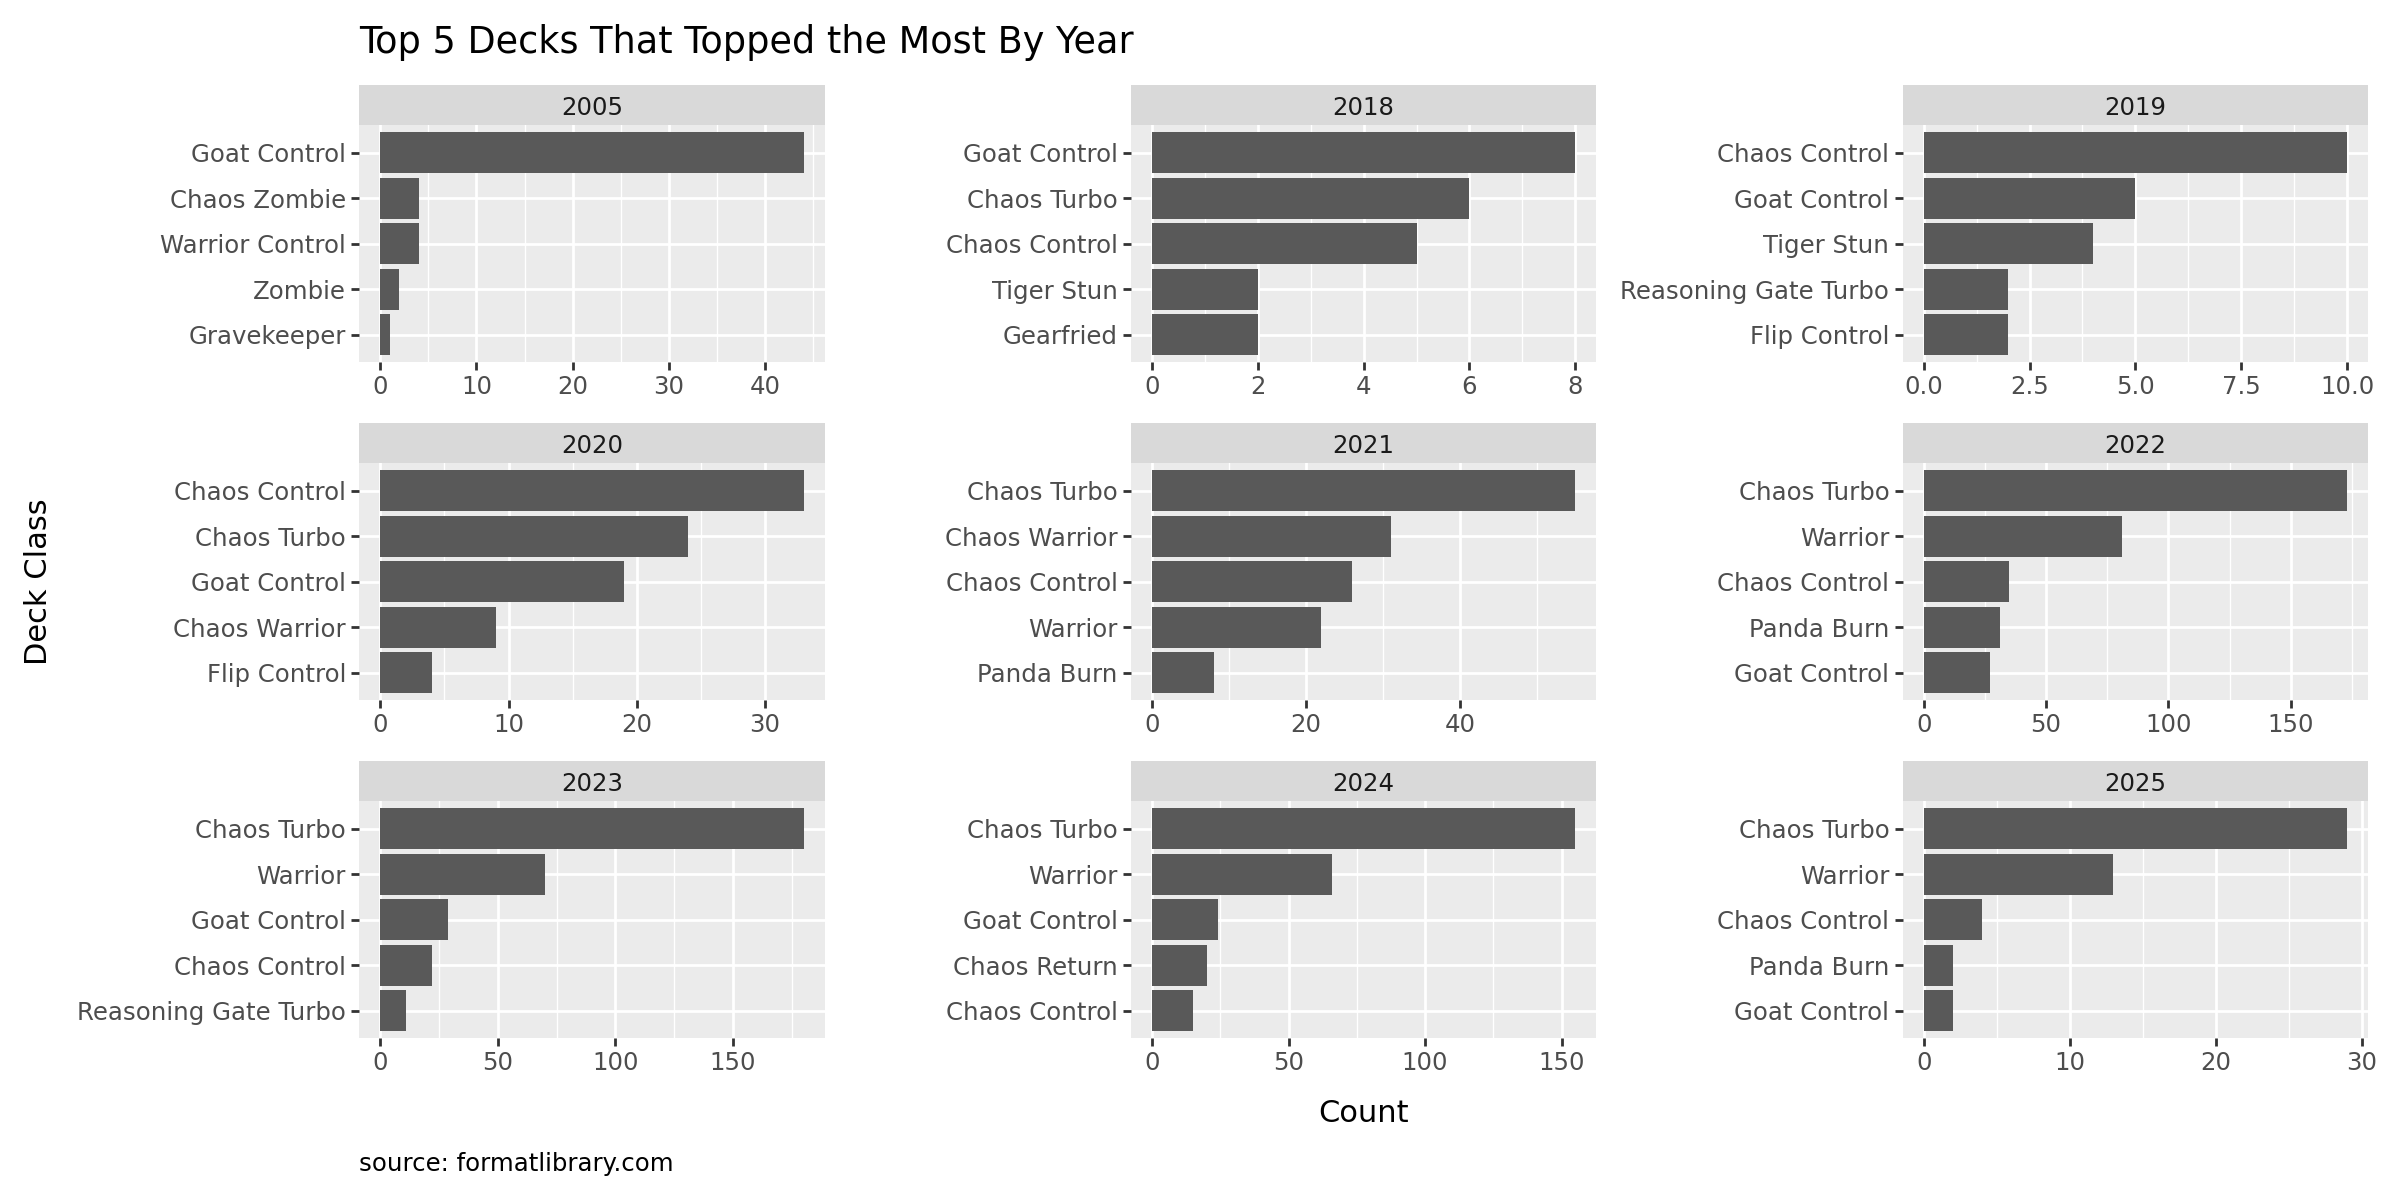

In [12]:
deck_class_count_by_year = (
    grouped_event_decks.with_columns(year=pl.col("published_date").dt.year())
    .group_by(["year", "deck_class"])
    .len()
    .select(pl.all().top_k_by("len", k=5).over("year", mapping_strategy="explode"))
)

(
    ggplot(
        reorder_within(deck_class_count_by_year, "deck_class", "year", "len").to_pandas()
    )
    + geom_bar(
        aes(x="reorder(deck_class_ordered, len)", y="len"),
        stat="identity",
    )
    + coord_flip()
    + scale_x_discrete(labels=lambda x: [item.split("___")[0] for item in x])
    + facet_wrap("~year", scales="free")
    + labs(
        title="Top 5 Decks That Topped the Most By Year",
        x="Deck Class",
        y="Count",
        caption="source: formatlibrary.com",
    )
    + theme(
        figure_size=(12, 6),
        title=element_text(ha="left"),
        axis_title_x=element_text(ha="center")
    )
)

#### Deck Size Distribution

How many cards are in each deck?

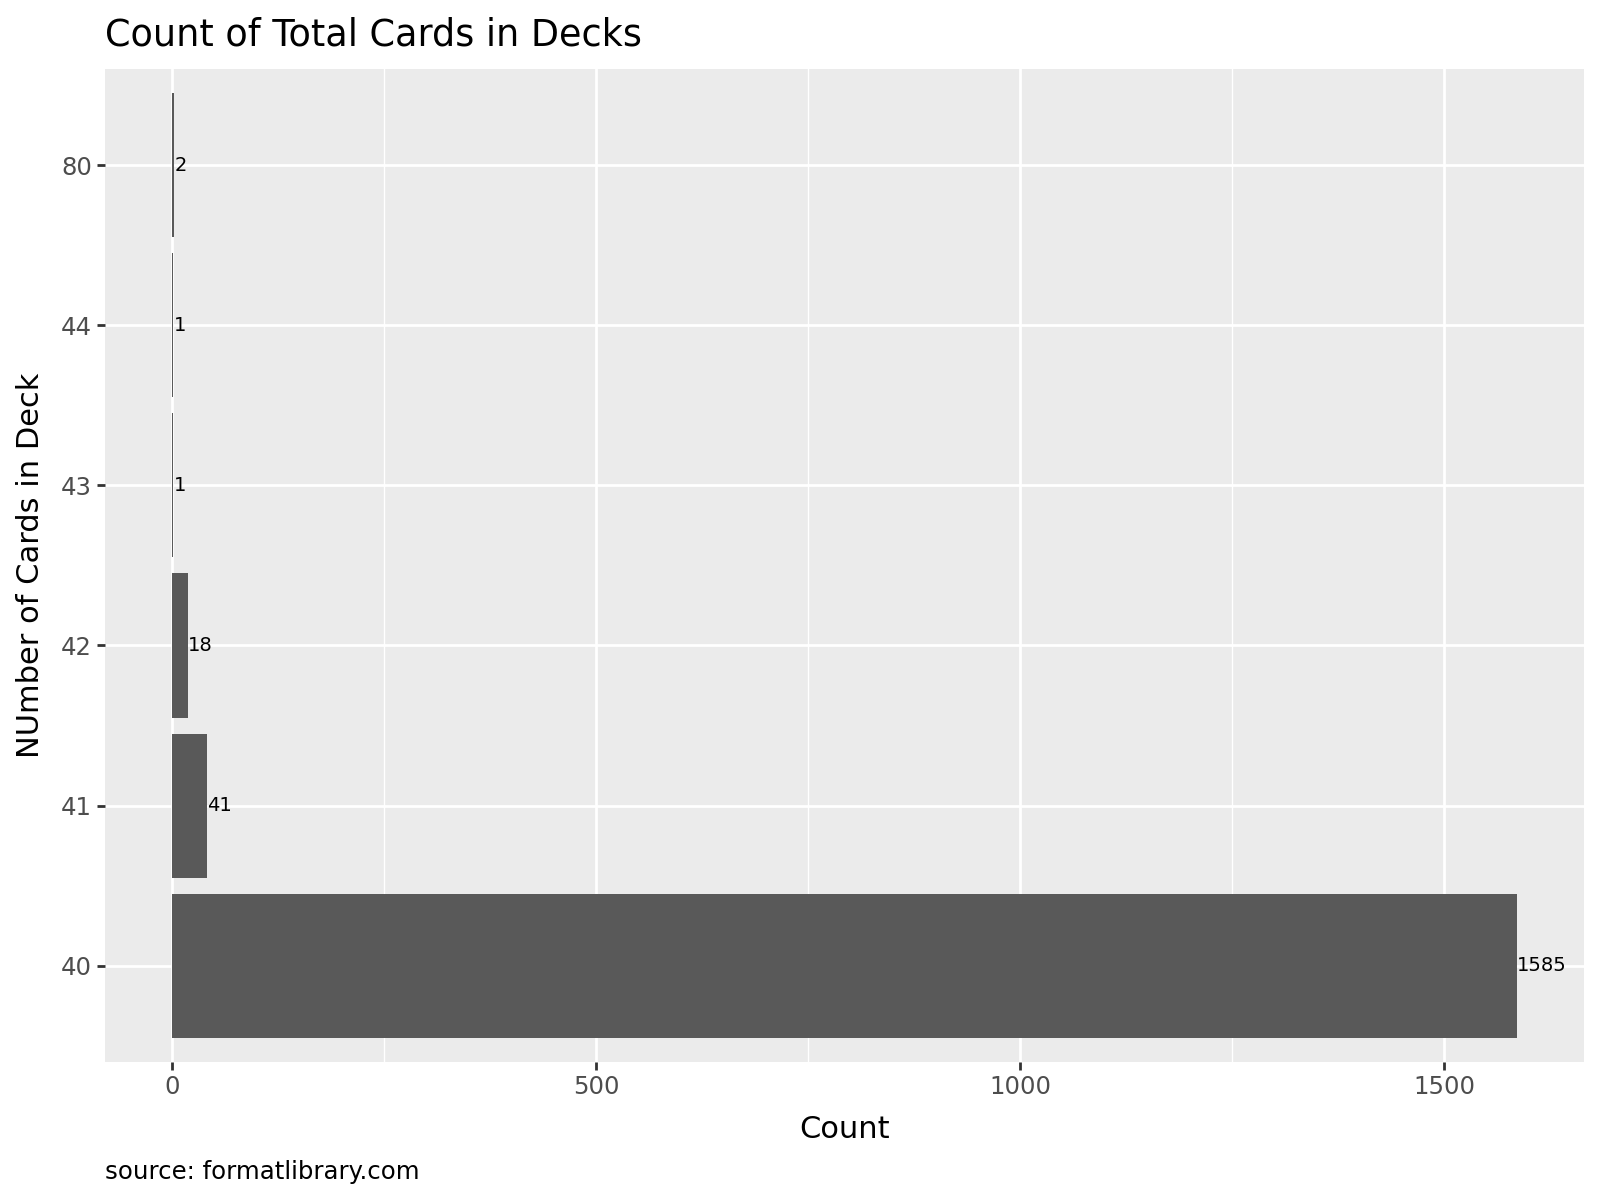

In [13]:
total_cards_count = (
    event_decks.group_by("url")
    .agg(
        pl.col("deck_class").first().alias("deck_class"),
        pl.col("card_amount").sum().alias("total_cards"),
    )
    .group_by("total_cards")
    .len()
    .sort("len", descending=True)
    .with_columns(
        total_cards=pl.col("total_cards").cast(pl.String),
    )
)

(
    ggplot(total_cards_count.to_pandas())
    + geom_bar(
        aes(
            x="total_cards",
            y="len",
        ),
        stat="identity",
    )
    + coord_flip()
    + geom_text(
        aes(
            x="total_cards",
            y="len",
            label="len",
        ),
        ha="left",
        va="center",
        nudge_y=0.3,
        size=7,
    )
    + labs(
        title="Count of Total Cards in Decks",
        x="NUmber of Cards in Deck",
        y="Count",
        caption="source: formatlibrary.com",
    )
    + theme(
        figure_size=(8, 6),
        title=element_text(ha="left"),
        axis_title_x=element_text(ha="center")
    )
)

### Data Quality

If you've been following along, you may have noticed some irregularities with the data. This section will be taking a closer look at these irregularities and decide how to deal with them.


#### Card Count

In [the last section]("#deck-size-distribution"), it's great to see that there were no decks with cards below 40 but there were decks with over 60 cards - that's illegal.

There's only 5 cases, all with 80 cards in the main deck, let's take a look at each.

In [14]:
with pl.Config(fmt_str_lengths=1000, tbl_width_chars=1000):
    print(
        event_decks.group_by("url")
        .agg(
            pl.col("deck_class").first().alias("deck_class"),
            pl.col("card_amount").sum().alias("total_cards"),
        )
        .filter(pl.col("total_cards") == 80)
        .sort("deck_class")
    )

shape: (2, 3)
┌───────────────────────────────────────┬─────────────┬─────────────┐
│ url                                   ┆ deck_class  ┆ total_cards │
│ ---                                   ┆ ---         ┆ ---         │
│ str                                   ┆ str         ┆ i64         │
╞═══════════════════════════════════════╪═════════════╪═════════════╡
│ https://formatlibrary.com/decks/232   ┆ Chaos Turbo ┆ 80          │
│ https://formatlibrary.com/decks/37064 ┆ Drain Burn  ┆ 80          │
└───────────────────────────────────────┴─────────────┴─────────────┘


Each deck here has 40 cards in it's main deck, not 80. We're just going to remove these from our datasets.


#### Label Verification

When we looked at all the deck types in [this section](#deck-type-analysis), there were some deck classes that were very similar. eg. Chaos Warrior Turbo vs Chaos Warrior and Jar Turbo vs Empty Jar. Let's take a look at them and see if they can share the same deck type.

The reason this matters is to reduce dimensionality once we start modeling. Don't want to lower our precision because the model can't decide between irrelevant differences.

In [15]:
with pl.Config(fmt_str_lengths=100, tbl_width_chars=100):
    print(
        grouped_event_decks.filter(pl.col("deck_class") == "Chaos Warrior Turbo").select(
            "deck_class", "deck_builder", "url"
        )
    )

shape: (11, 3)
┌─────────────────────┬─────────────────┬───────────────────────────────────────┐
│ deck_class          ┆ deck_builder    ┆ url                                   │
│ ---                 ┆ ---             ┆ ---                                   │
│ str                 ┆ str             ┆ str                                   │
╞═════════════════════╪═════════════════╪═══════════════════════════════════════╡
│ Chaos Warrior Turbo ┆ picatron        ┆ https://formatlibrary.com/decks/50120 │
│ Chaos Warrior Turbo ┆ picatron        ┆ https://formatlibrary.com/decks/48206 │
│ Chaos Warrior Turbo ┆ Asim            ┆ https://formatlibrary.com/decks/48216 │
│ Chaos Warrior Turbo ┆ picatron        ┆ https://formatlibrary.com/decks/44031 │
│ Chaos Warrior Turbo ┆ icephoeniix.    ┆ https://formatlibrary.com/decks/42504 │
│ …                   ┆ …               ┆ …                                     │
│ Chaos Warrior Turbo ┆ icephoeniix.    ┆ https://formatlibrary.com/decks/40635 │
│

After looking at these examples, it seems that `Chaos Warrior Turbo` are those Nano-like decks with a warrior package and thunder dragon. This is distinctive enough to keep the labels separated.

Next, let's take a look at Empty Jar vs Jar Turbo.

In [16]:
with pl.Config(fmt_str_lengths=100, tbl_width_chars=100):
    print(
        grouped_event_decks.filter(pl.col("deck_class") == "Jar Turbo").select(
            "deck_class", "deck_builder", "url"
        )
    )

shape: (1, 3)
┌────────────┬──────────────┬──────────────────────────────────────┐
│ deck_class ┆ deck_builder ┆ url                                  │
│ ---        ┆ ---          ┆ ---                                  │
│ str        ┆ str          ┆ str                                  │
╞════════════╪══════════════╪══════════════════════════════════════╡
│ Jar Turbo  ┆ james arc    ┆ https://formatlibrary.com/decks/2085 │
└────────────┴──────────────┴──────────────────────────────────────┘


There's only 1 occurence of this deck type, which means it doesn't really matter to go over since we'll need to filter them out later for the model. However, this example from james seems pretty similar to the `Heavy Slump` deck type.

Next, let's take a look at Zombie Turbo vs Zombies.

In [17]:
with pl.Config(fmt_str_lengths=100, tbl_width_chars=100):
    print(
        grouped_event_decks.filter(pl.col("deck_class") == "Zombie Turbo").select(
            "deck_class", "deck_builder", "url"
        )
    )

shape: (2, 3)
┌──────────────┬──────────────┬───────────────────────────────────────┐
│ deck_class   ┆ deck_builder ┆ url                                   │
│ ---          ┆ ---          ┆ ---                                   │
│ str          ┆ str          ┆ str                                   │
╞══════════════╪══════════════╪═══════════════════════════════════════╡
│ Zombie Turbo ┆ AlephYa2     ┆ https://formatlibrary.com/decks/22215 │
│ Zombie Turbo ┆ ATJ          ┆ https://formatlibrary.com/decks/19079 │
└──────────────┴──────────────┴───────────────────────────────────────┘


Personally, these Zombie Turbo examples are distinctive enough with regular Zombie decks to have as a separate deck class. The Zombie deck type itself is too varied to distinguish beyond the zombie monsters.


#### Edge Cases (Min Tails)

Originally, I was going to go over the decks with small sample since these are prime for mislabels. That Crane Turbo speculation I listed before, was actually mislabled for Chaos Turbo. As are the decks in Other. Decks that are before the modern era, eg. the 2005 decks, also doesn't have very relevant data for today's usage that they should also be filtered out.

Since all of these examples are on samples lower than 5, they were either going to be filtered out anyway during the modeling process or be insigificant to correct to bigger sample deck types.

In summary, we're going to make the following adjustments:

- Filter for deck classes after 2006
- Filter for deck classes with a sample >= 5
- Filter out decks that has 80 cards

In [18]:
decks_before_2006 = (
    grouped_event_decks.filter(pl.col("published_date") < pl.date(2006, 1, 1))
    .get_column("url")
    .to_list()
)

decks_with_low_deck_class_sample = (
    grouped_event_decks.filter(pl.col("deck_class").count().over("deck_class") < 5)
    .sort("deck_class")
    .get_column("url")
    .to_list()
)

decks_with_80_cards = (
    event_decks.group_by("url")
    .agg(
        pl.col("card_amount").sum().alias("total_cards"),
    )
    .filter(pl.col("total_cards") == 80)
    .get_column("url")
    .to_list()
)

decks_to_remove = list(
    set(decks_before_2006 + decks_with_low_deck_class_sample + decks_with_80_cards)
)

# Remove decks that are not useful for the model
model_data = event_decks.filter(~pl.col("url").is_in(decks_to_remove))

## 4. Model Development


### Data Processing

#### Preparation

In [19]:
base_df = (
    model_data
    .select(
        "url",
        "deck_class",
        "card_name",
        "card_amount"
    )
    .select(
        pl.exclude('card_amount').repeat_by('card_amount').explode()
    )
    .to_pandas()
)

# Function to print pandas df with same styling as polars describe
def print_df(df, head=3):
    print(
        pl
        .from_pandas(df)
        .head(head)
        .describe
    )

print_df(base_df, 5)

<bound method DataFrame.describe of shape: (5, 3)
┌─────────────────────────────────┬────────────┬─────────────────────────────────┐
│ url                             ┆ deck_class ┆ card_name                       │
│ ---                             ┆ ---        ┆ ---                             │
│ str                             ┆ str        ┆ str                             │
╞═════════════════════════════════╪════════════╪═════════════════════════════════╡
│ https://formatlibrary.com/deck… ┆ Warrior    ┆ Black Luster Soldier - Envoy o… │
│ https://formatlibrary.com/deck… ┆ Warrior    ┆ Blade Knight                    │
│ https://formatlibrary.com/deck… ┆ Warrior    ┆ Blade Knight                    │
│ https://formatlibrary.com/deck… ┆ Warrior    ┆ Blade Knight                    │
│ https://formatlibrary.com/deck… ┆ Warrior    ┆ Breaker the Magical Warrior     │
└─────────────────────────────────┴────────────┴─────────────────────────────────┘>


#### Train-Test Split

Higher level train-test split on the urls to ensure no data leakage once we create partial copies.

In [20]:
# Splitting the URLS instead of the datasets to use later
train_urls, test_urls = train_test_split(
    base_df['url'].unique(),
    test_size=0.2,
    random_state=42,
    stratify=base_df.groupby('url')['deck_class'].first().values
)

# Create training and testing datasets
train_data = base_df[base_df['url'].isin(train_urls)]
test_data = base_df[base_df['url'].isin(test_urls)]

print(f"Train: {len(train_urls)} decks \nTest: {len(test_urls)} decks")

Train: 1227 decks 
Test: 307 decks


#### Data Augmentation

Create partial copies of each deck

In [21]:
# Function to create augmented data
def create_augmented_data(deck_data):
    augmented = []
    for _, deck_df in deck_data.groupby('url'):
        # Get the deck type
        deck_class = deck_df['deck_class'].iloc[0]
        
        # Add full deck
        augmented.append({
            'deck_class': deck_class,
            'card_names': deck_df['card_name'].tolist(),
        })
        
        # Create partial decks (20%, 40%, 60%, 80%)
        for p in [0.2, 0.4, 0.6, 0.8]:
            # Randomly remove cards based on fraction
            sampled = deck_df.sample(frac=p, replace=False)
            
            # Add partial deck
            augmented.append({
                'deck_class': deck_class,
                'card_names': sampled['card_name'].tolist(),
            })
            
    return pd.DataFrame(augmented)

# Create augmented datasets
train_aug = create_augmented_data(train_data)
test_aug = create_augmented_data(test_data)

print(f"Train: {len(train_aug)} decks \nTest: {len(test_aug)} decks")

Train: 6135 decks 
Test: 1535 decks


#### Feature Engineering

#### TF-IDF Pipeline

In [22]:
# Prepare card names for TF-IDF
# Join card names into a single string for each deck
train_aug['card_names_str'] = train_aug['card_names'].apply(lambda x: '|'.join(x))
test_aug['card_names_str'] = test_aug['card_names'].apply(lambda x: '|'.join(x))

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')

# Transform card names into TF-IDF features
X_train = tfidf.fit_transform(train_aug['card_names_str'])
X_test = tfidf.transform(test_aug['card_names_str'])

# Label encoding
le = LabelEncoder()

# Turns deck type labels into numbers
y_train = le.fit_transform(train_aug['deck_class'])
y_test = le.transform(test_aug['deck_class'])

# Print augmentation
print_df(train_aug, 3)

<bound method DataFrame.describe of shape: (3, 3)
┌─────────────┬─────────────────────────────────┬─────────────────────────────────┐
│ deck_class  ┆ card_names                      ┆ card_names_str                  │
│ ---         ┆ ---                             ┆ ---                             │
│ str         ┆ list[str]                       ┆ str                             │
╞═════════════╪═════════════════════════════════╪═════════════════════════════════╡
│ Chaos Turbo ┆ ["Black Luster Soldier - Envoy… ┆ Black Luster Soldier - Envoy o… │
│ Chaos Turbo ┆ ["Graceful Charity", "Mirror F… ┆ Graceful Charity|Mirror Force|… │
│ Chaos Turbo ┆ ["Card Destruction", "Dekoichi… ┆ Card Destruction|Dekoichi the … │
└─────────────┴─────────────────────────────────┴─────────────────────────────────┘>


#### TF Plot

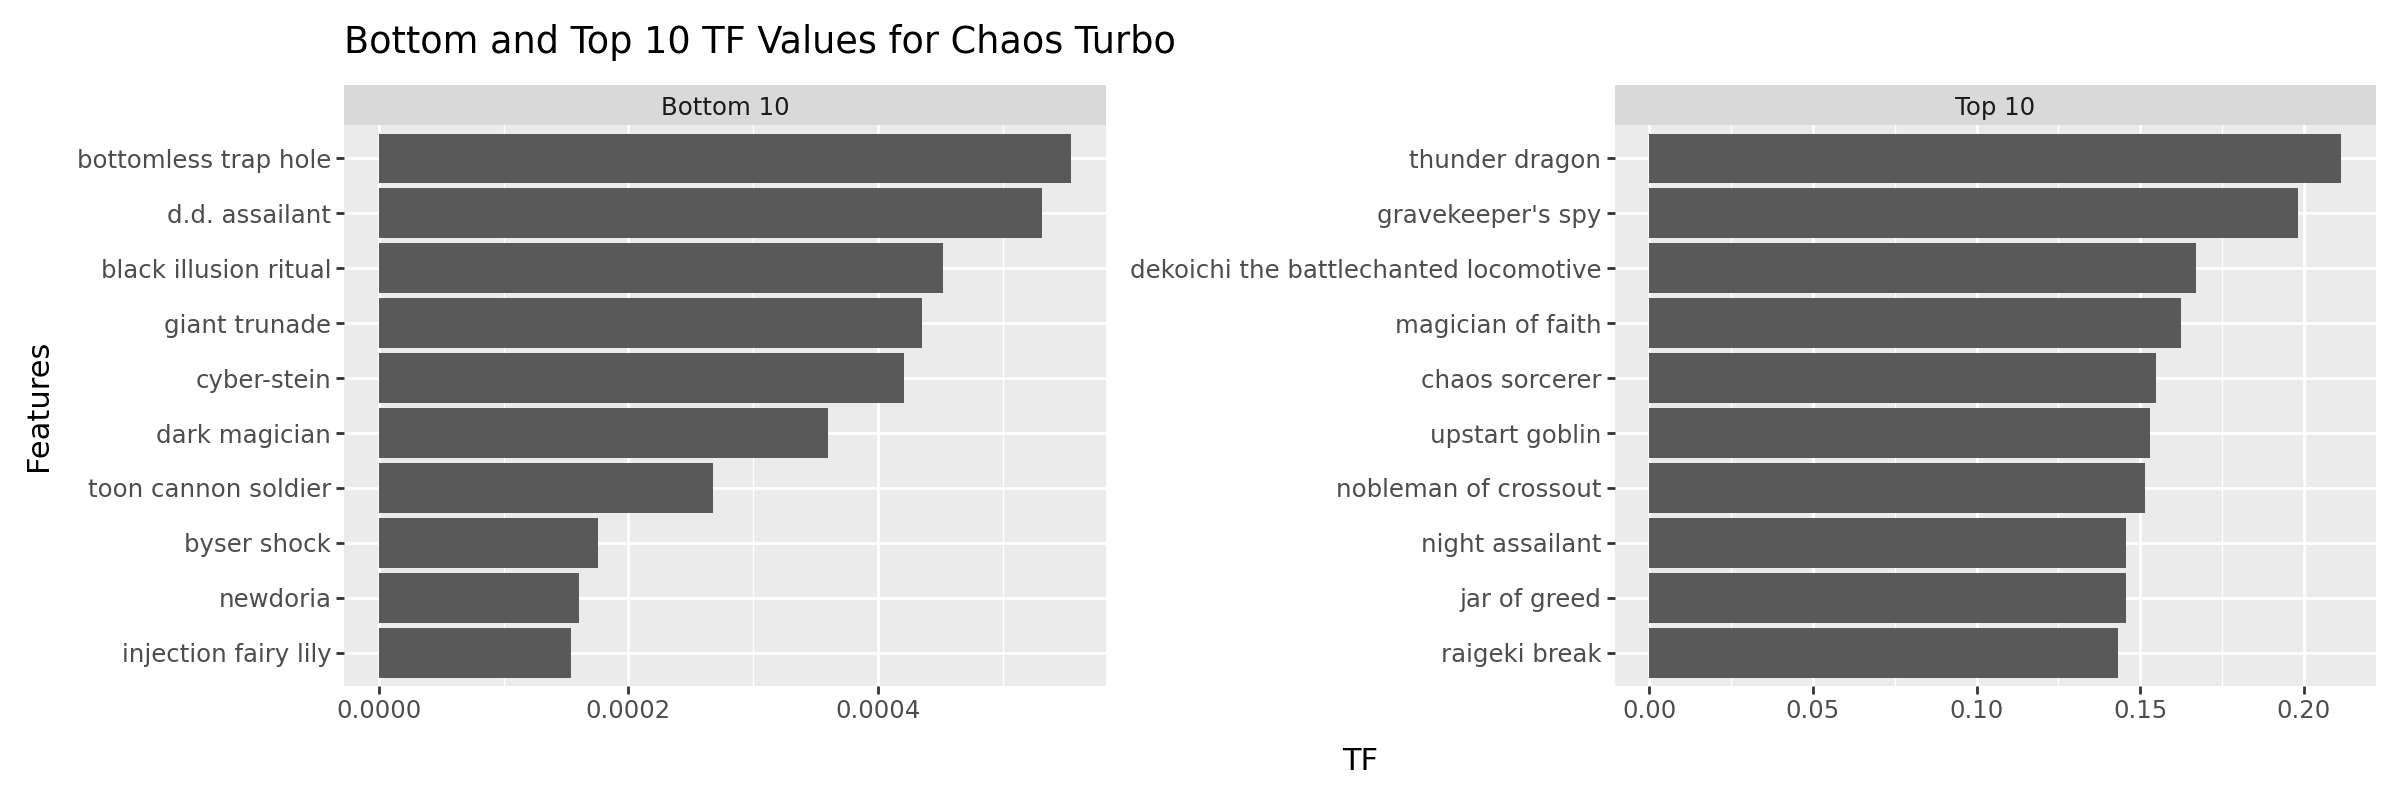

In [23]:
# Select a deck class to analyze
selected_deck_class = 'Chaos Turbo'

# Get the subset of data for the selected deck class
mask = train_aug['deck_class'] == selected_deck_class
selected_data = train_aug[mask]

# Calculate TF scores for the selected deck class
tfidf_selected = TfidfVectorizer(token_pattern=r'[^|]+')
X_selected = tfidf_selected.fit_transform(selected_data['card_names_str'])
tf_scores = np.asarray(X_selected.mean(axis=0)).flatten()

# Get the card names from the selected TF-IDF
card_names_selected = tfidf_selected.get_feature_names_out()

# Create a DataFrame for TF scores
tf_df = pd.DataFrame({
    'card': card_names_selected,
    'tf': tf_scores
})

# Sort by TF score in descending order
tf_df = tf_df.sort_values('tf', ascending=False)

# Get the global IDF scores and filter for cards in the selected deck class
idf_scores = tfidf.idf_
idf_df = pd.DataFrame({
    'card': tfidf.get_feature_names_out(),
    'idf': idf_scores
})

# Filter IDF scores for cards present in the selected deck class
idf_df = idf_df[idf_df['card'].isin(tf_df['card'])]

# Sort by IDF score in descending order
idf_df = idf_df.sort_values('idf', ascending=False)

# Create a combined DataFrame for plotting
plot_data = pd.concat([
    tf_df.head(10).assign(type='Top 10'),
    tf_df.tail(10).assign(type='Bottom 10'),
    idf_df.head(10).assign(type='Top 10'),
    idf_df.tail(10).assign(type='Bottom 10')
], axis=0)

# TF Plot
(
    ggplot(
        plot_data[plot_data["idf"].isna()]
    )
    + geom_bar(
        aes(x="reorder(card, tf)", y="tf"),
        stat = "identity"
    )
    + coord_flip()
    + facet_wrap("~type", scales="free")
    + labs(
        title=f"Bottom and Top 10 TF Values for {selected_deck_class}",
        x="Features",
        y="TF"
    )
    + theme(
        figure_size=(12, 4),
        title=element_text(ha="left"),
        axis_title_x=element_text(ha="center")
    )
)

#### IDF Plot

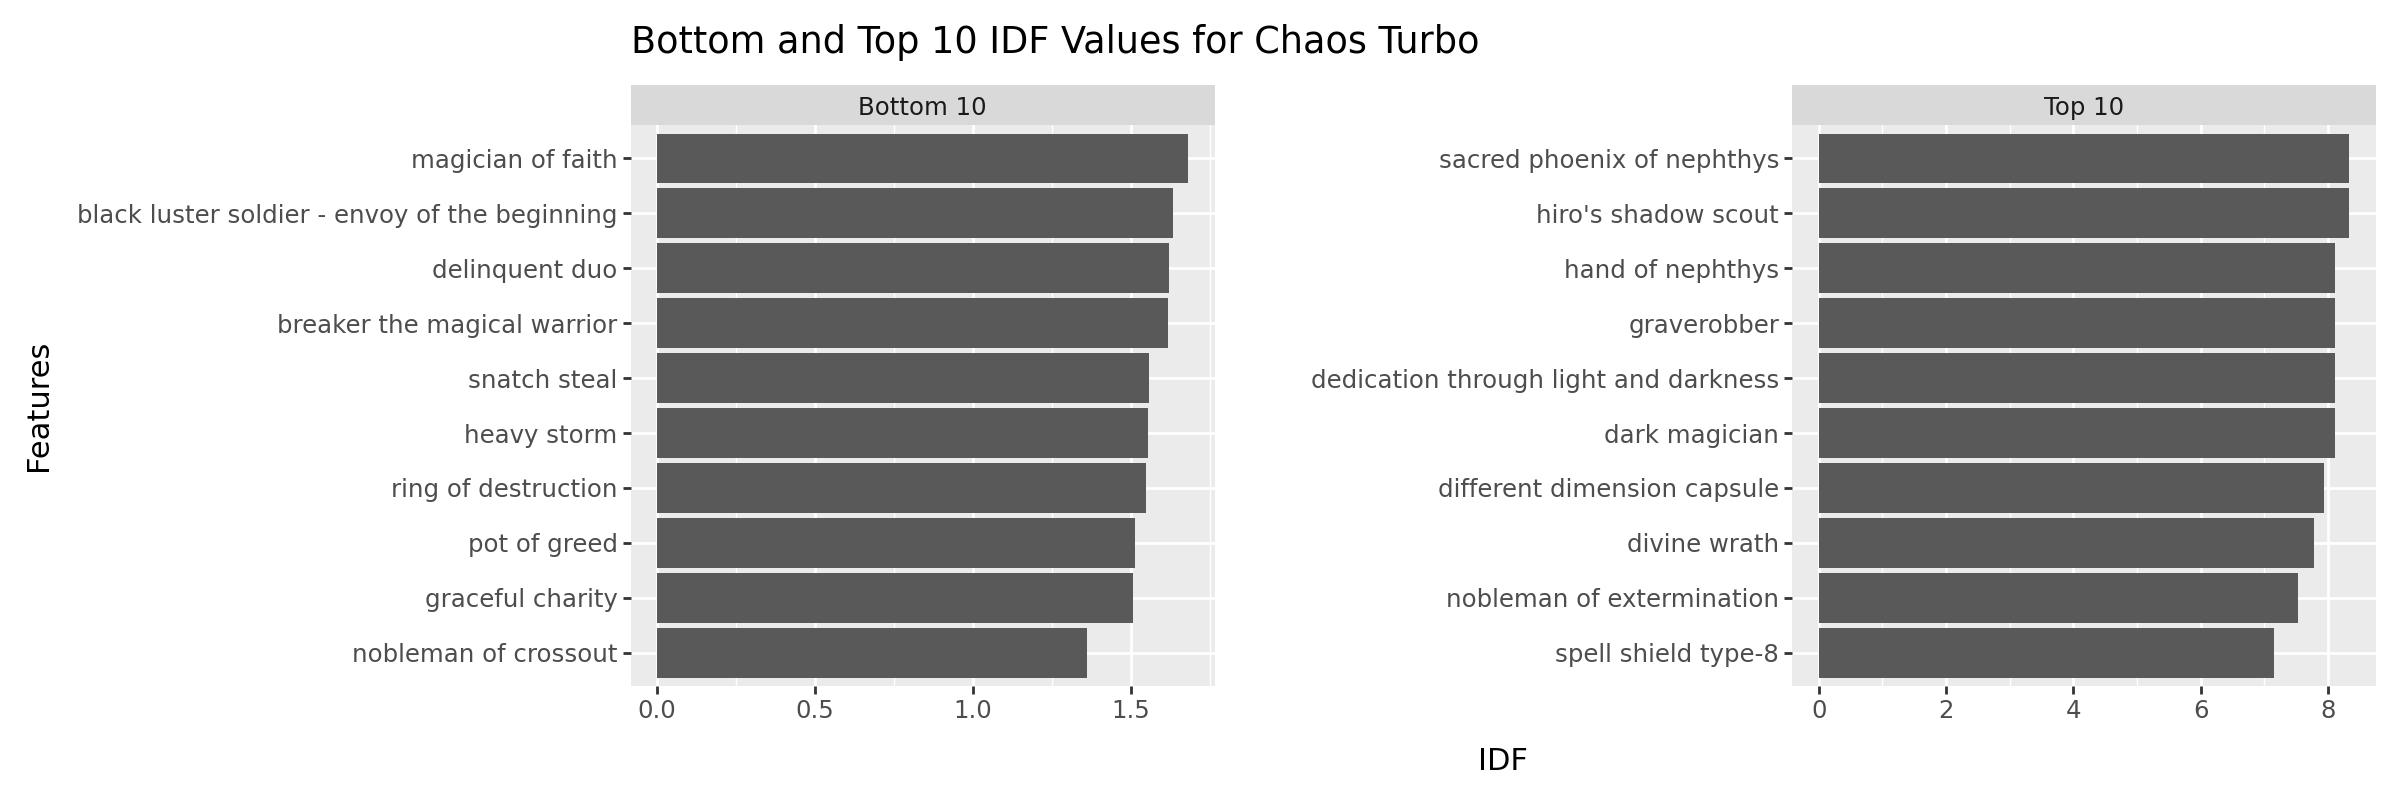

In [24]:
(
    ggplot(
        plot_data[plot_data["tf"].isna()]
    )
    + geom_bar(
        aes(x="reorder(card, idf)", y="idf"),
        stat = "identity"
    )
    + coord_flip()
    + facet_wrap("~type", scales="free")
    + labs(
        title=f"Bottom and Top 10 IDF Values for {selected_deck_class}",
        x="Features",
        y="IDF"
    )
    + theme(
        figure_size=(12, 4),
        title=element_text(ha="left"),
        axis_title_x=element_text(ha="center")
    )
)

### Model Training

#### Class Imbalance Handling

In [25]:
# Apply the sampling strategy
oversampler = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

# Create a DataFrame to compare
print_df(
    pd.DataFrame({
        'original': pd.Series(le.inverse_transform(y_train)).value_counts(),
        'oversampled': pd.Series(le.inverse_transform(y_train_os)).value_counts()
    })
    .reset_index(names="card")
    .sort_values("original", ascending=False),
    5
)

<bound method DataFrame.describe of shape: (5, 3)
┌───────────────┬──────────┬─────────────┐
│ card          ┆ original ┆ oversampled │
│ ---           ┆ ---      ┆ ---         │
│ str           ┆ i64      ┆ i64         │
╞═══════════════╪══════════╪═════════════╡
│ Chaos Turbo   ┆ 2465     ┆ 2465        │
│ Warrior       ┆ 1030     ┆ 2465        │
│ Chaos Control ┆ 610      ┆ 2465        │
│ Goat Control  ┆ 455      ┆ 2465        │
│ Panda Burn    ┆ 280      ┆ 2465        │
└───────────────┴──────────┴─────────────┘>


#### Cross Validation

In [26]:
# Cross-validation with hyperparameter tuning
param_dist = {
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2]
}

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Create cv folds
search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,  
    n_jobs=10,
    random_state=42,
    scoring='accuracy'
)

# Fit the training data on the cv folds
search.fit(X_train_os, y_train_os)

# Get our best model
best_model = search.best_estimator_

print("\nBest Parameters:", search.best_params_)


Best Parameters: {'subsample': 0.7, 'reg_lambda': 0, 'reg_alpha': 0.1, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6}


#### Cross Validation Plot

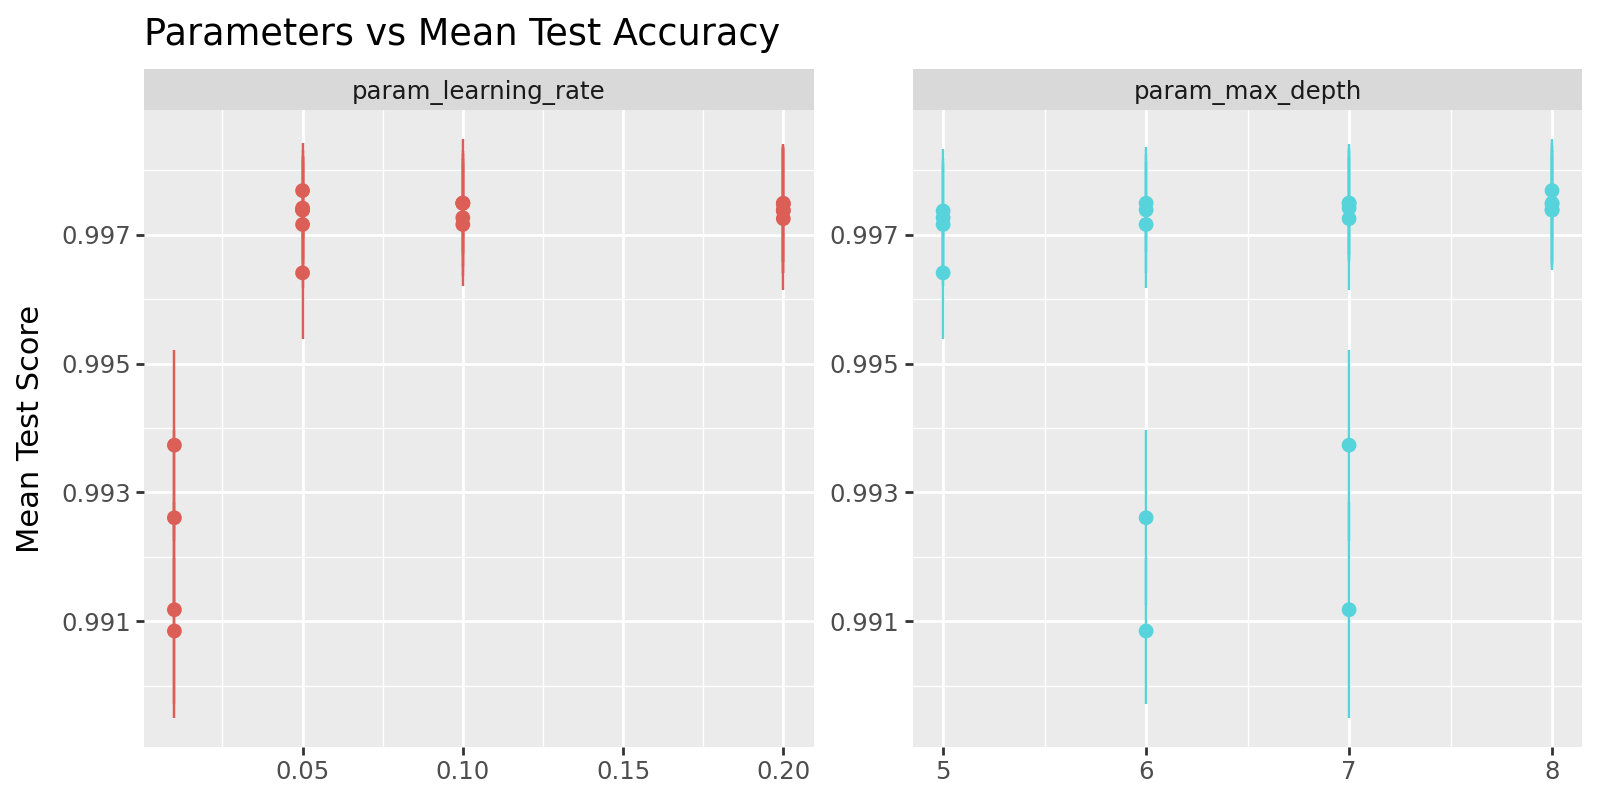

In [27]:
# Parameters
key_parameters = ['param_max_depth', 'param_learning_rate']

# Create pandas dataframe from params and test performance
cv_plot_data = (
    pd
    .DataFrame(search.cv_results_)
    .loc[:, key_parameters + ['mean_test_score', 'std_test_score']]
    .melt(id_vars=['mean_test_score', 'std_test_score'], value_vars=key_parameters)
    .rename(columns={
        'variable': 'parameter',
        'value': 'param_value'
    })
)

# Cross validation plot
(
    ggplot(
        cv_plot_data, 
        aes(
            x='param_value',
            y='mean_test_score',
            ymin='mean_test_score - std_test_score',
            ymax='mean_test_score + std_test_score',
            color='parameter'
        ))
    + geom_pointrange()
    + facet_wrap('~parameter', scales='free')
    + labs(
        title="Parameters vs Mean Test Accuracy",
        x="",
        y='Mean Test Score'
    )
    + theme(
        figure_size=(8, 4),
        legend_position="none",
        title=element_text(ha="left")
    )
)

### Model Evaluation

#### Overall Performance

In [28]:
# Use the model on the test dataset
y_pred = best_model.predict(X_test)

# Print classification report on full test dataset
print(classification_report(
    le.inverse_transform(y_test),
    le.inverse_transform(y_pred),
    zero_division=0
))

                      precision    recall  f1-score   support

        Bazoo Return       0.00      0.00      0.00         0
             Cat OTK       0.79      0.95      0.86        20
       Chaos Control       0.92      0.86      0.89       140
     Chaos Recruiter       0.36      0.80      0.50         5
        Chaos Return       0.91      0.82      0.86        65
         Chaos Turbo       0.96      0.98      0.97       645
       Chaos Warrior       0.91      0.71      0.80        45
 Chaos Warrior Turbo       1.00      0.60      0.75         5
          Drain Burn       1.00      0.50      0.67        10
          Earth Beat       0.53      0.90      0.67        10
       Economics FTK       1.00      1.00      1.00         5
        Flip Control       0.00      0.00      0.00         5
        Flip Warrior       0.38      0.15      0.21        20
           Gearfried       0.83      1.00      0.91         5
        Goat Control       0.94      0.94      0.94       155
       

#### Partial Deck Performance

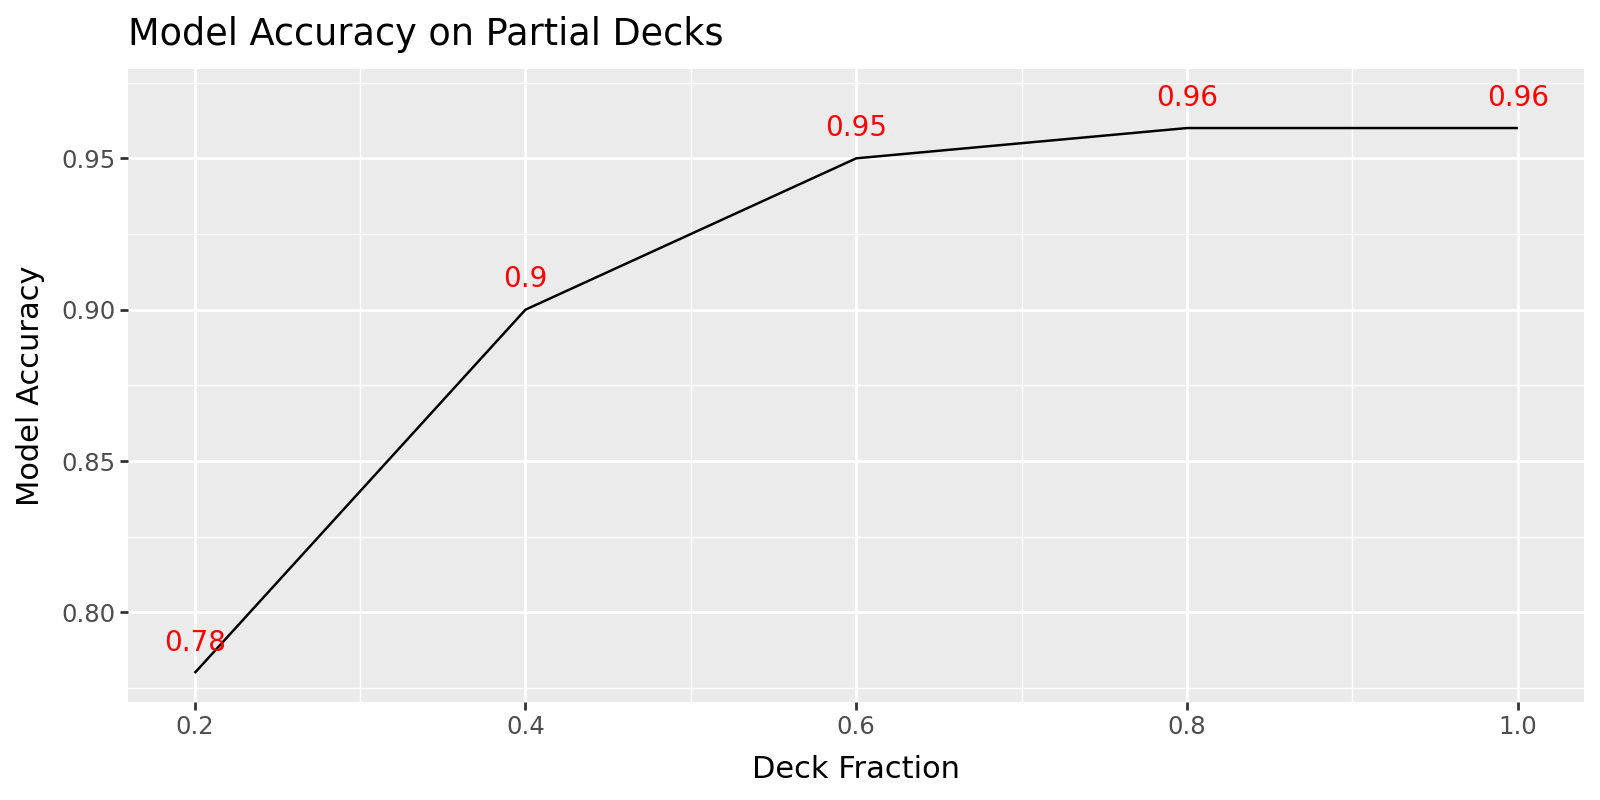

In [29]:
def test_model_on_fraction(
    full_dataset,
    test_urls_list,
    tfidf_vectorizer,
    label_encoder,
    trained_model,
    sample_fraction
):
    def create_test_samples(deck_data, fraction):
        test_samples = []
        for _, deck in deck_data.groupby('url'):
            deck_class = deck['deck_class'].iloc[0]
            sampled_cards = deck.sample(frac=fraction, random_state=42, replace=False)
            test_samples.append({
                'deck_class': deck_class,
                'card_names': sampled_cards['card_name'].tolist()
            })
        return pd.DataFrame(test_samples)

    # Prepare the test data
    test_data = (
        full_dataset
        .select(
            "url",
            "deck_class",
            "card_name",
            "card_amount"
        )
        .filter(pl.col("url").is_in(test_urls_list))
        .select(
            pl.exclude('card_amount').repeat_by('card_amount').explode()
        )
        .to_pandas()
    )

    # Create test samples with the specified fraction
    test_samples_df = create_test_samples(test_data, sample_fraction)

    # Prepare the data for prediction
    test_samples_df['card_names_str'] = test_samples_df['card_names'].apply(lambda x: '|'.join(x))
    X_test = tfidf_vectorizer.transform(test_samples_df['card_names_str'])
    y_test = label_encoder.transform(test_samples_df['deck_class'])

    # Make predictions
    y_pred = trained_model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(
        label_encoder.inverse_transform(y_test),
        label_encoder.inverse_transform(y_pred)
    )

    # Return the result as a DataFrame
    return pd.DataFrame({
        'fraction': [sample_fraction],
        'accuracy': [round(accuracy, 2)]
    })

# Test the model with different fractions and collect results
results = []
for fraction in [.2, .4, .6, .8, 1]:
    result_df = test_model_on_fraction(
        full_dataset=model_data,
        test_urls_list=test_urls,
        tfidf_vectorizer=tfidf,
        label_encoder=le,
        trained_model=best_model,
        sample_fraction=fraction
    )
    results.append(result_df)

# Combine all results into a single DataFrame
frac_plot_df = pd.concat(results, axis=0).reset_index(drop=True)

(
    ggplot(frac_plot_df)
    + geom_line(
        aes(x="fraction", y="accuracy")
    )
    + geom_text(
        aes(x="fraction", y="accuracy", label="accuracy"),
        nudge_y=.01,
        size=10,
        color="red"
    )
    + labs(
        title="Model Accuracy on Partial Decks",
        x="Deck Fraction",
        y="Model Accuracy"
    )
    + theme(
        figure_size=(8, 4),
        title=element_text(ha="left"),
        axis_title_x=element_text(ha="center")
    )
)

#### Confusion Matrix

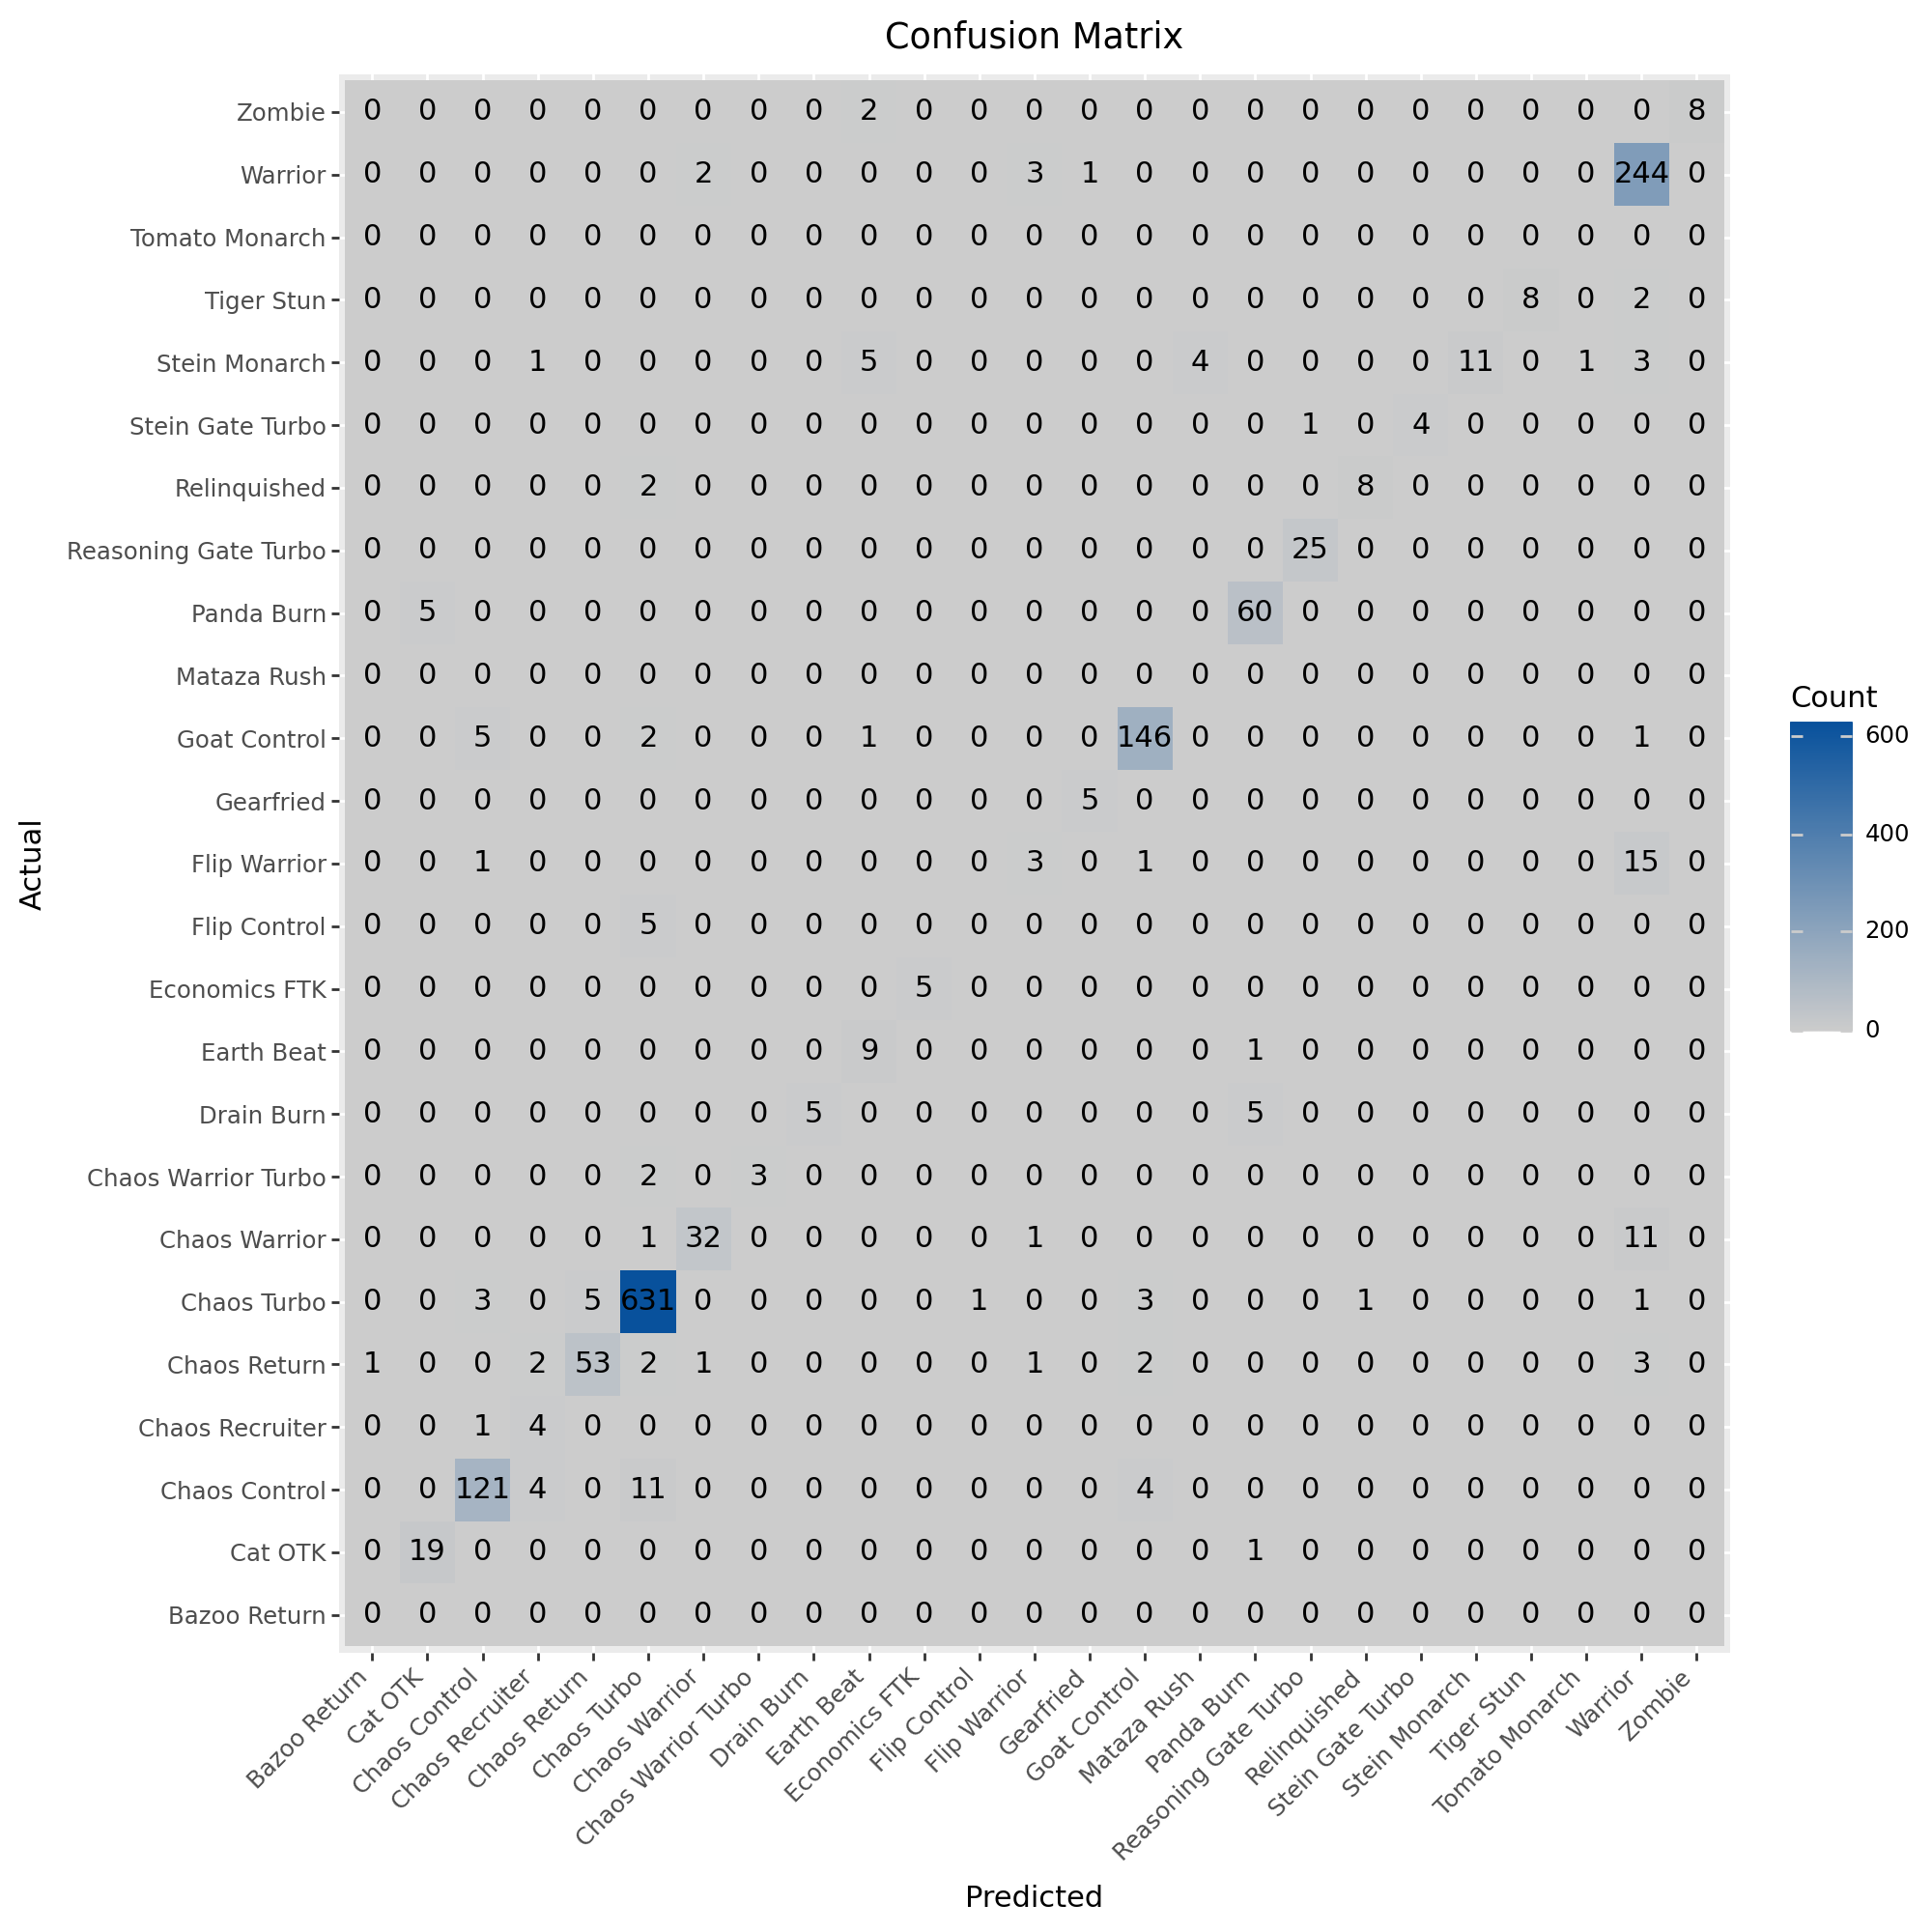

In [30]:
# Create confusion matrix and get unique classes
cm = confusion_matrix(y_test, y_pred)
unique_classes = np.unique(np.concatenate([y_test, y_pred]))
labels = le.inverse_transform(unique_classes)

# Turn confusion matrix to pandas df
cm_df = (
    pd
    .DataFrame(cm, index=labels, columns=labels)
    .reset_index(names="Actual")
    .melt(
        id_vars="Actual", 
        var_name="Predicted", 
        value_name="Count"
    )
)

# Confusion matrix plot
(
    ggplot(cm_df, aes(x="Predicted", y="Actual", fill="Count"))
    + geom_tile()
    + geom_text(aes(label="Count"))
    + scale_fill_gradient(low='#CCCCCC', high='#08519C')
    + theme(
        figure_size=(10, 10),
        axis_text_x=element_text(rotation=45, hjust=1)
        )
    + labs(
        title="Confusion Matrix"
    )
)

### Save the Model

Save the model, tf-idf, and label encoder.

In [32]:
joblib.dump(tfidf, 'gfwldata/models/deck_classifier/tfidf.joblib')
joblib.dump(le, 'gfwldata/models/deck_classifier/label_encoder.joblib')
joblib.dump(best_model, 'gfwldata/models/deck_classifier/xgboost_model.joblib')

['gfwldata/models/deck_classifier/xgboost_model.joblib']